# **The Molecular Treasure Hunt: Part 4: Understanding the meaning of your docking scores**

*An &#8491;ngstrom sized adventure by Sarah Harris (Leeds Physics) and Geoff Wells (UCL Pharmacy)*

"*You have learned the lessons of your masters by rote," ... "But such childish lore shall not help you, now they are all fled away.*"

# Introduction
In Parts 2 and 3 of your treasure hunt, you obtained poses for approximately 2000 ligands against a selection of protein conformers (hopefully ~10 - but the more the better - because dynamics is so important!!). This is a huge amount of data, and to make any sense of it we need to make decisions about which are the "best" hits. This is currently a somewhat subjective (and flawed) process, and is the subject of international docking competitions in which research groups attempt to predict experimentally determined protein-ligand complexes, and their affinities (see https://www.capri-docking.org/).

# What Part 4 will reveal to you!
You will probably find that you have far too much information to analyse visually. In Part 4, we process and manipulate our results, to take us closer to the heart of our quest!!

## A few things to think about before we start...

## Drug design considerations
In drug design programmes, "fragment hits" typically have high $\mu M$ to low $m M$ $K_{i}$ values, where the $K_{i}$ is the equilibrium dissociation constant for the ligand, and represents the probability that the ligand is bound or unbound at a given concentration:

\begin{equation*}
K_{i}   = \frac{[L][P]}{[LP]}
\end{equation*}

where [L] is the concentration of the ligand, [P] is the concentration of the protein and [LP] is the concentration of the ligand-protein complex.

Fragment hits then need to undergo further chemical refinement to produce a putative drug (e.g. via fragment growth or linking).

"Hit" compounds tend to be larger molecules that we consider promising and worthy of further structure-activity relationship studies. For these, we might expect $K_{i}$ values in the low $\mu M$ range. Further along the development pipeline, we have "lead" compounds, which may progress to preclinical development. We may expect $K_{i}$ values in the low $n M$ range for these molecules (depending on the target and its tractability).

How close do we get in our virtual study???

## Why thermodynamics matters
One of the major uncertainties is how we interpret our docking scores in terms of a dissociation constant between the protein and the ligand. This is due to the difficulty in calculating thermodynamic properties (which are ensemble averages over around Avogadro's number of molecular entities) from single snapshots obtained by a dock. Moreover, there are additional complications such as induced fit of the receptor, environmental conditions (e.g. salt concentration). The problem is that what we need for affinity is **free energy**, whereas what we can calculate from a single static protein structure is just the **energy** because the **entropy** term is missing when we don't include all possible protein, ligand and solvent conformations. This is currently impossible to compute. 

If you find this difficult to understand, you are not alone, and this issue is one of the concepts we explore in our treasure hunt when we consider multiple protein receptor conformations. It is interesting to note that the Vina_BE does not quote actual units in the output, possibly to dissuade users from making direct comparisions with experimental binding free energy data. Vina_BE is in the units of KCal/mol (http://autodock.scripps.edu/faqs-help/faq/how-autodock-4-converts-binding-energy-kcal-mol-into-ki). 

To convert from Vina_BE to an estimate of the ligand dissociation constant ($K_{i}$), that we call Vina_Ki in this notebook, we use the following equation:


\begin{equation*}
K_{i}   = e^{\Delta G/RT}
\end{equation*}

Here we interpret $\Delta$G as being equivalent to the Vina_BE, R is the ideal gas constant and T is the temperature. We need the temperature to be in Kelvin (K) and R to be in Kcal/mol/K. Because the $K_{i}$ is a function of the free energy, $\Delta$G, it tells us about probabilities. For example, a dissociation constant ($K_{i}$) of $10^{-3} M$ means that for each unbound ligand, 1000 are bound to the protein. Conversely, a dissociation constant of $10^{3} M$ means that for each 1000 unbound ligand molecules only one is bound to the protein receptor. Note that below we quote Vina_Ki values in $\mu M$ because ligand $K_{i}$ values often span the $m M$ to $n M$ range of concentrations.

It would also be possible to consider the association constant ($K_{a}$) where:

\begin{equation*}
K_{a}   = \frac{1}{K_{i}}
\end{equation*}

Which of course, from thermodynamics, implies that:

\begin{equation*}
K_{a}   = e^{-\Delta G/RT}
\end{equation*}

The additional rescoring functions estimate values for the pIC$_{50}$ of the ligands (this is the -log$_{10}$ of the IC$_{50}$, which is the concentration of the ligand that inhibits 50% of protein 'activity'). An important distinction between $K_{i}$ and IC$_{50}$ is that the latter are assay dependent and affected by, for example, the concentration of the protein and ligand. However, because IC$_{50}$ values are directly measured in experiments, they are more prevalent than $K_{i}$ values in the literature because they can be measured in high-throughput experiments, sometimes using liquid handling robotics. Conversely, equilibrium dissociation constants ($K_{d}$) can be determined using direct binding techniques such as isothermal titration calorimetry, microscale thermophoresis or surface plasmon resonance methods, althought these can be lower throughput and more time consuming. 

Generally, all scores should therefore be viewed as a rank, rather than a prediction of binding free energy.

In [1]:
#This imports the python modules that we need for the notebook...
#import sys
#import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mpl_toolkits
from mpl_toolkits.mplot3d import Axes3D
from glob import glob
import seaborn as sns
import scipy.cluster.hierarchy as shc

In [2]:
#This function extracts the docking and properties info from the various results files in our directory
def extract_docking_results_from_mol2(filename):
    
    DockedFilePath = filename
    DockedFilePrefix = DockedFilePath.split(".")[0]
    DockedFile = DockedFilePrefix.split("VinaResults_")[1]
    Protein_conf = []
    Name = []
    Vina_BE = []
    MW = []
    clogP = []
    nonHatoms = []
    Vina_LE = []
    Vina_LipE = []
    Vina_Ki = []
    CC = []
    HydroC = []
    HBonds = []
    SaltB = []
    PiPi_Par = []
    PiPi_Perp = []
    Pi_Cat = []
    HalB = []
    RF_v3 = []
    NN = []
    PLEC_rf = []

    with open(DockedFilePath, 'r') as f:
        for line in f:
            if line.startswith("########## Name:"):
                Name.append(str(line.split()[2]))
                Protein_conf.append(DockedFile)  
            if line.startswith("########## Vina_BE:"):
                if float(line.split()[2])<0:
                    Vina_BE.append(float(line.split()[2]))
                    #Here the gas constant R is in the units Kcal/mol/K and the temperature is 300 K 
                    #Ki (the inhibitor dissociation constant) is in micromolar units
                    Vina_Ki.append((math.exp((float(line.split()[2]))/(0.001987*300))*1000000))
                else:
                    #Here we set the Vina_BE and Vina_Ki to 0 if the values are greater than 0 (which may be an indication that the compound does not fit in the binding site and/or grid box)
                    #You should look out for these zero values in your graphs!
                    Vina_BE.append(0)
                    Vina_Ki.append(0)
                
                    
                    
            if line.startswith("########## MW:"):
                MW.append(float(line.split()[2]))
            if line.startswith("########## clogP:"):
                clogP.append(float(line.split()[2]))
            if line.startswith("########## nonHatoms:"):
                nonHatoms.append(int(line.split()[2]))
            if line.startswith("########## Vina_LE:"):
                Vina_LE.append(float(line.split()[2]))
            if line.startswith("########## Vina_LipE:"):
                Vina_LipE.append(float(line.split()[2]))
            if line.startswith("########## Close_contacts:"):
                CC.append(int(line.split()[2]))
            if line.startswith("########## Hydrophob_contacts:"):
                HydroC.append(int(line.split()[2]))
            if line.startswith("########## HBonds:"):
                HBonds.append(int(line.split()[2]))
            if line.startswith("########## Salt_Bridges:"):
                SaltB.append(int(line.split()[2]))
            if line.startswith("########## Pi-Pi_Parallel:"):
                PiPi_Par.append(int(line.split()[2]))
            if line.startswith("########## Pi-Pi_Perpendicular:"):
                PiPi_Perp.append(int(line.split()[2]))
            if line.startswith("########## Pi-Cation:"):
                Pi_Cat.append(int(line.split()[2]))
            if line.startswith("########## Halogen_Bonds:"):
                HalB.append(int(line.split()[2]))
            if line.startswith("########## RFScore_v3:"):
                RF_v3.append(float(line.split()[2]))
            if line.startswith("########## NNScore:"):
                NN.append(float(line.split()[2]))
            if line.startswith("########## PLECScore_rf:"):
                PLEC_rf.append(float(line.split()[2]))
                
    
    #The units of Vina_BE are kcal/mol. R = 1.987 cal/mol/K.
    df = pd.DataFrame(list(zip(Protein_conf, 
                               Name, 
                               Vina_BE, 
                               Vina_Ki, 
                               MW, 
                               nonHatoms, 
                               clogP, 
                               Vina_LE, 
                               Vina_LipE, 
                               CC, 
                               HydroC, 
                               HBonds, 
                               SaltB, 
                               PiPi_Par, 
                               PiPi_Perp, 
                               Pi_Cat, 
                               HalB, 
                               RF_v3, 
                               NN, 
                               PLEC_rf)), 
                   columns =['Protein_Conf', 
                             'Ligand_Name', 
                             'Vina_BE', 
                             'Vina_Ki', 
                             'MW', 
                             'nonHatoms', 
                             'clogP', 
                             'Vina_LE', 
                             'Vina_LipE', 
                             'Close_Contacts', 
                             'Hphob_Contacts', 
                             'HBonds', 
                             'Salt_Bridges', 
                             'Pi-Pi_Par', 
                             'Pi-Pi_Perp', 
                             'Pi-Cation', 
                             'Hal_Bonds', 
                             'RFScore_v3', 
                             'NNScore', 
                             'PLECScore_rf'])
            
    return(df)
    f.close()

# Creating 'pandas dataframes' from our docking data
Here we are going to read in the results from our results folder, and process them to produce a special python object called a **pandas dataframe**. This python data structure effectively represents your data in a table, which then helps us to extract the information we need and to make plots of our data.

In [3]:
# This defines our receptor structures (all of these files happen to have the same prefix, the starting structure (xal structure) is xxx_00.pdb)
path_results_filenames = glob('MTH_Results_Rescored/VinaResults_*.mol2')
path_results_filenames.sort()
#print(path_results_filenames)
dataframes_list = []
for path_results_filename in path_results_filenames:
#    results_filename = path_results_filename.split("/")[1]
    df_out = extract_docking_results_from_mol2(path_results_filename)
    dataframes_list.append(df_out)
    
total_dataframes = pd.concat(dataframes_list, ignore_index=True)    

Here we take a look at the Pandas dataframe - it looks neat and it is easy to understand!
It is also quite large at this stage! But the aim of this second part of this treasure hunt is to reduce this data set to a manageable size.

In [4]:
#Save the data frame in a csv file format
total_dataframes.to_csv('rescored_docking_results.csv', index=False)

In [5]:
#This lists all of our results...
total_dataframes

,Protein_Conf,Ligand_Name,Vina_BE,Vina_Ki,MW,nonHatoms,clogP,Vina_LE,Vina_LipE,Close_Contacts,Hphob_Contacts,HBonds,Salt_Bridges,Pi-Pi_Par,Pi-Pi_Perp,Pi-Cation,Hal_Bonds,RFScore_v3,NNScore,PLECScore_rf
0,5rlh_b_rescored,Z1012638850,-2.851,8372.903413,69.062,8,0.115,-0.356,-2.966,1,0,6,0,0,0,0,0,3.811,3.724,3.546
1,5rlh_b_rescored,Z1037576366,-3.254,4258.596492,92.075,9,0.063,-0.362,-3.317,1,0,1,0,0,0,0,0,3.801,3.564,3.537
2,5rlh_b_rescored,Z104472264,-3.302,3929.122985,99.108,7,-0.464,-0.472,-2.838,0,4,0,2,0,0,0,0,4.444,3.616,3.766
3,5rlh_b_rescored,Z104472278,-3.442,3106.685242,90.083,9,-0.224,-0.382,-3.218,0,5,0,0,0,0,0,0,3.863,4.685,3.754
4,5rlh_b_rescored,Z104472692,-2.539,14131.450161,65.053,6,-0.663,-0.423,-1.876,0,0,0,0,0,0,0,0,4.031,3.365,3.465
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307,7rdy_prep_rescored,Z825308062,-3.252,4272.908683,93.083,10,0.277,-0.325,-3.529,1,1,7,0,0,0,0,0,4.008,3.577,3.514
308,7rdy_prep_rescored,Z940713324,-2.689,10987.598083,79.100,6,1.082,-0.448,-3.771,0,9,0,0,0,0,0,0,3.350,3.507,3.549
309,7rdy_prep_rescored,Z955123660,-2.595,12864.336266,73.051,8,-2.983,-0.324,0.388,1,0,3,0,0,0,0,0,4.403,3.743,3.921
310,7rdy_prep_rescored,Z991531024,-3.407,3294.555639,92.079,9,-0.253,-0.379,-3.154,2,5,0,0,0,0,0,0,4.104,4.778,3.754


# Plotting our data and saving our graphs
Now we try to understand our results by plotting some basic graphs and charts. This is important, because it is impossible to know how we should best choose hits unless we first assess the trends across the whole data set. Notice that we consider data distributions in our treasure hunt more often than averages.

In the first example we save the graphical output as a picture file that you can use in presentations and reports. There is a line in the code: "plt.savefig('Vina_BE_vs_compounds.png')" that you can paste into other cells in the notebook if you want to save the chart or graph. Remember to change the file name to something relevant to your output!

## Looking at the whole dataset
First we will look at the Vina_BE for each ligand, across each of the protein conformers. Having around 2000 ligands means that this graph is very busy. We concluded this this representation of our data wasn't very informative.

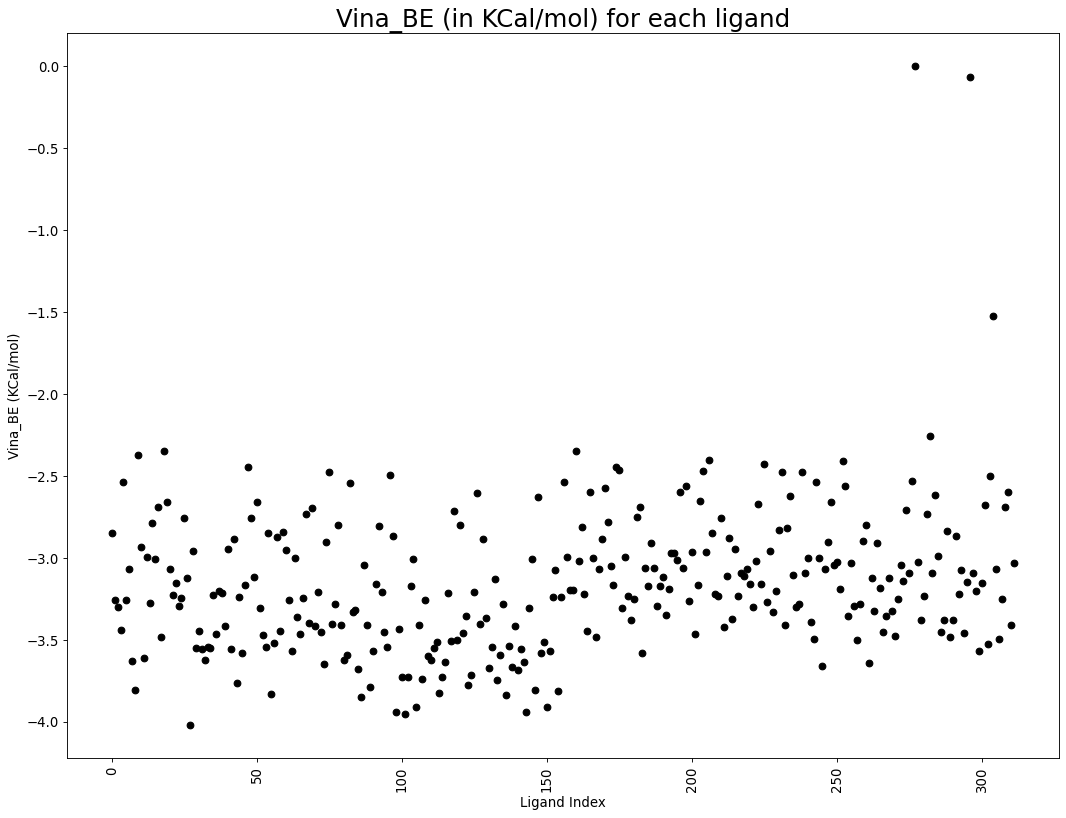

In [6]:
#We are plotting binding energy for each ligand: each point represents one ligand and one protein conformation.
plt.figure(figsize=(16,12), dpi= 80)
plt.plot(total_dataframes.index, total_dataframes.Vina_BE, 'o', color='black');
plt.title('Vina_BE (in KCal/mol) for each ligand', fontsize=22)
plt.xticks(fontsize=12, rotation=90)
plt.xlabel('Ligand Index', fontsize=12)
plt.ylabel('Vina_BE (KCal/mol)', fontsize=12)
plt.yticks(fontsize=12)
plt.savefig('Vina_BE_vs_compounds.png')
plt.show()

## Looking at distributions
As we have so much data, it is probably best to take a look at distributions, rather than the actual values (as we tried above). Here we plot the Vina_BE (KCal/mol), the Cyscore (*mystery units*) and the number of hydrogen bonds formed by the receptor protein with the ligand in each case.

We can immediately see whether our two different scoring functions give similiar or different results for our docking scores across the protein receptor conformers by comparing the Vina_BE and Cyscore distribution functions. 

array([[<AxesSubplot:title={'center':'Hphob_Contacts'}>]], dtype=object)

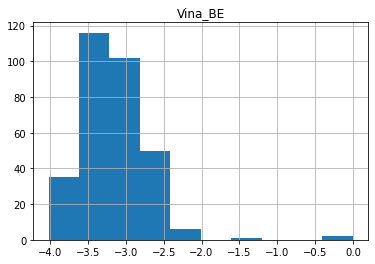

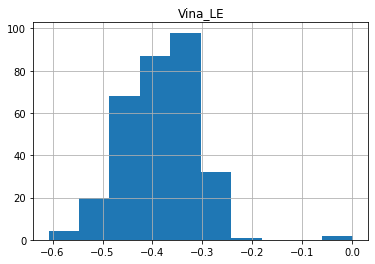

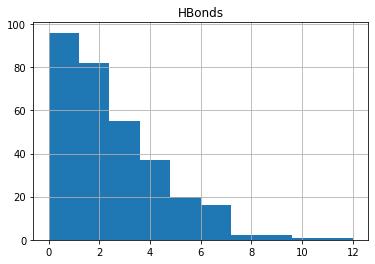

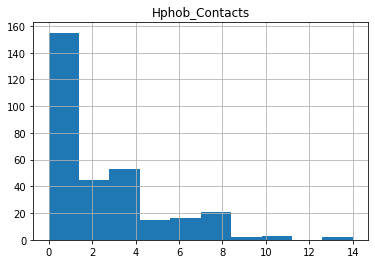

In [7]:
#A series of histograms to tell us about the distributions of our docking results...
total_dataframes.hist('Vina_BE')
total_dataframes.hist('Vina_LE')
total_dataframes.hist('HBonds')
total_dataframes.hist('Hphob_Contacts')

We can use our special pandas dataframe to sort the results by Vina_BE, putting the lowest (e.g. most favourable) energy first. We can the visualise this version of our dataframe that is "sorted by Vina_BE" to check we understand what we are plotting (this may not be included in the pdf version).

In [8]:
sort_by_BE = total_dataframes.sort_values('Vina_BE')
sort_by_BE

,Protein_Conf,Ligand_Name,Vina_BE,Vina_Ki,MW,nonHatoms,clogP,Vina_LE,Vina_LipE,Close_Contacts,Hphob_Contacts,HBonds,Salt_Bridges,Pi-Pi_Par,Pi-Pi_Perp,Pi-Cation,Hal_Bonds,RFScore_v3,NNScore,PLECScore_rf
27,5rlh_b_rescored,Z1245635875,-4.022,1174.174339,98.083,11,-0.418,-0.366,-3.604,3,1,7,0,0,0,0,0,4.350,4.171,3.931
101,6zsl_prep_rescored,Z1198152541,-3.951,1322.696879,93.064,8,-0.354,-0.494,-3.597,1,1,1,0,0,0,0,0,4.164,4.409,3.470
98,6zsl_prep_rescored,Z1079179236,-3.940,1347.331571,94.071,7,0.546,-0.563,-4.486,3,1,3,0,0,0,0,0,4.433,4.184,3.437
143,6zsl_prep_rescored,Z57127349,-3.938,1351.859651,95.056,8,-0.866,-0.492,-3.072,0,2,4,0,0,0,0,0,4.425,3.424,3.579
150,6zsl_prep_rescored,Z803153778,-3.911,1414.499244,93.064,8,-1.094,-0.489,-2.817,2,3,3,0,0,0,0,0,4.158,3.707,3.598
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
160,7rdx_prep_rescored,Z104472692,-2.345,19567.138882,65.053,6,-0.663,-0.391,-1.682,0,0,1,0,0,0,0,0,3.756,3.676,3.442
282,7rdy_prep_rescored,Z237573792,-2.253,22832.571527,65.073,8,-0.982,-0.282,-1.271,0,6,2,0,0,0,0,0,3.308,3.221,3.639
304,7rdy_prep_rescored,Z59181971,-1.524,77566.626350,84.053,8,-0.448,-0.191,-1.076,0,3,5,0,0,0,0,0,4.425,3.763,3.876
296,7rdy_prep_rescored,Z56887677,-0.065,896692.659639,95.079,10,0.454,-0.007,-0.519,0,1,3,0,0,0,0,0,4.296,4.014,3.722


## We always see this 'S'-shaped profile!
We can now produce a ranked (waterfall) plot of the Vina_BE vs compound. We have observed that this has a very characteristic "S" shape for all ligand libraries and protein receptors we have tried so far. We think that the best "hits" can only be those in the first steep region of the curve, because in the shallow region a small change in binding energy (e.g. Vina_BE in KCal/mol) produces a large change in rank for the compound.

<AxesSubplot:xlabel='index', ylabel='Vina_BE'>

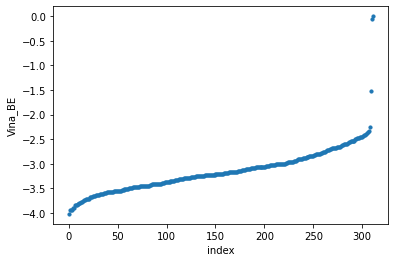

In [9]:
sort_by_BE.reset_index(drop=True, inplace=True)
sort_by_BE.reset_index().plot(kind='scatter', x='index', y='Vina_BE', s=10)

Here we plot the Vina_BE as a function of molecular weight (and the points are coloured by the clogP value, that estimates the lipophilicity of the ligand). Do you see any trends between the Vina_BE and the 'size' of your ligands? Does this trend make sense in terms of the molecular recognition of the protein receptor binding site?

<AxesSubplot:title={'center':'Vina_BE (in KCal/mol) as a function of molecular weight MW (g/mol)'}, xlabel='MW', ylabel='Vina_BE'>

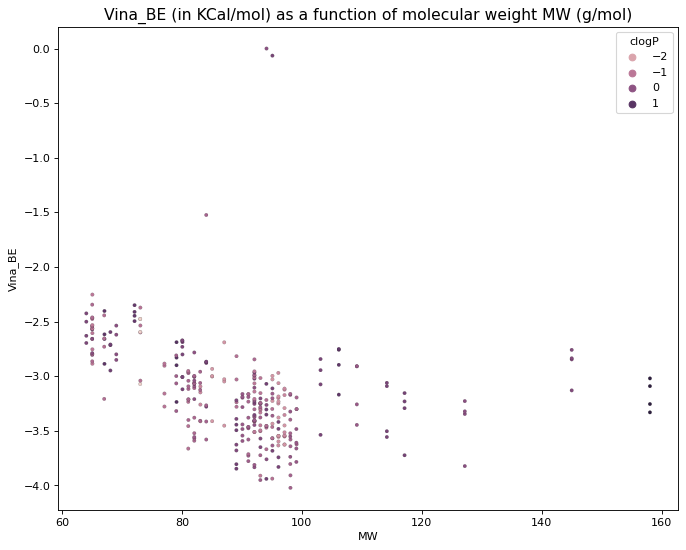

In [10]:
plt.figure(figsize=(10,8), dpi= 80)
plt.title('Vina_BE (in KCal/mol) as a function of molecular weight MW (g/mol)', fontsize=14)
sns.scatterplot(data=sort_by_BE, x='MW', y='Vina_BE', hue='clogP', s=10, edgecolor="black", linewidth=0.1)

Now we plot the same data as above but using the Vina_Ki in place of the Vina_BE. Because the Vina_Ki depends exponentially on the Vina_BE you will see that small changes in the predicted binding energy result in large differences in the inhibitor dissociation constant (Ki). Remember that smaller values of Ki imply a tighter binding of the ligand to the protein receptor.

<AxesSubplot:title={'center':'Vina_Ki (in $\\mu M$) as a function of molecular weight MW (g/mol)'}, xlabel='MW', ylabel='Vina_Ki'>

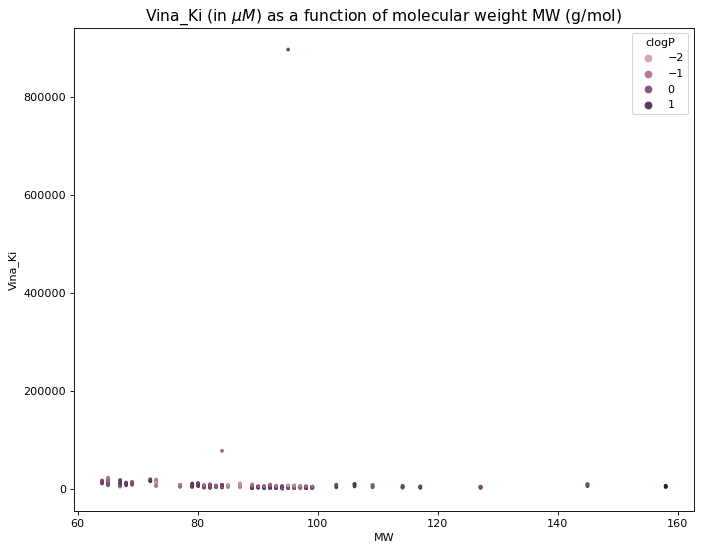

In [11]:
plt.figure(figsize=(10,8), dpi= 80)
plt.title('Vina_Ki (in $\mu M$) as a function of molecular weight MW (g/mol)', fontsize=14)
sns.scatterplot(data=sort_by_BE, x='MW', y='Vina_Ki', hue='clogP', s=10, edgecolor="black", linewidth=0.1)

## Looking at correlations
This next plot shows correlations in the numerical variables in the docking dataset.

Can you see any interesting correlations, or are there variables that are not as correlated as you might have hoped? Can you explain the correlations that you see?

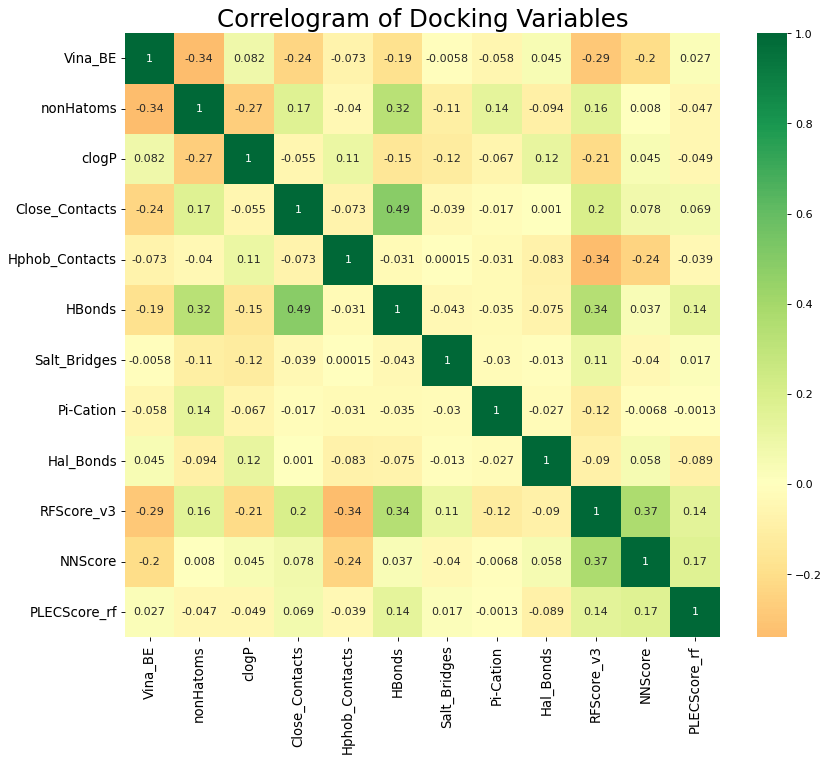

In [12]:
independent_variables = total_dataframes.drop(['MW', 'Vina_LE', 'Vina_LipE', 'Vina_Ki', 'Pi-Pi_Par', 'Pi-Pi_Perp'], axis=1)
# Plot
plt.figure(figsize=(12,10), dpi= 80)
sns.heatmap(independent_variables.corr(), xticklabels=independent_variables.corr().columns, yticklabels=independent_variables.corr().columns, cmap='RdYlGn', center=0, annot=True)

# Decorations
plt.title('Correlogram of Docking Variables', fontsize=22)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

## Observing the importance of dynamics and protein conformation
The next very informative plot is a version of our 'waterfall' plot for our ranked compounds, but now seperated so we can see how it depends on the protein receptor conformation.

We can see if including multiple protein conformations changes the shape of the distribution, and we can also see whether some protein conformations are better or worse at binding ligands. This plot is giving us direct information about the importance of dynamics (or other structural variations of the protein) on our docking results.

In [ ]:
plt.figure(figsize=(10,8), dpi= 80)
#sns.scatterplot(data=sort_by_BE, x='Ligand_Name', y='Vina_BE', hue='Protein_Conf')
#There is a conflict between seaborn 0.10.x and matplotlib 3.3.1 the hue term below is a workaround for this...
sns.scatterplot(data=sort_by_BE, x='Ligand_Name', y='Vina_BE', hue=sort_by_BE.Protein_Conf.tolist(), s=15, linewidth=0.1)

Now we are going to see if the Cyscore behaves in the same way as the Vina_BE. We are going to plot equivalent ranked plots because these were so informative in understanding the Vina_BE behaviour across multiple protein conformations and ligands. 

Does your graph have the same distinctive "S" shape as for the Vina_BE?

## Correlations with physicochemical properties
As well as binding "energies" (e.g. Vina_BE/Cyscore ranks), other properties of ligands are known to be important in molecular recognition. Pharmaceutical intution suggests that for a compound to engage in a molecular recognition event it must form some **hydrogen bonds** (which are distance and angle dependent interactions) or **electrostatic** interactions with the target, otherwise they will not be sufficiently chemically specific to the binding site. 

We can determine whether H-bonds are important to the Vina_BE, and consider also the other important physicochemical property **clogP**, which is an estimate of the octanol/water partition coefficient (a measure of the lipophilicity of the compound). This is important because how tells you how likely a drug is to cross a cell membrane, which relates to its bioavailability. One of *Lipinski's Rules of 5* is that logP should be no greater than 5 for an orally bioavailable drug. 

We can sometimes see that relatively non-polar compounds (clogP > 3-4) form few H-bonds in this type of plot, as expected.

In [ ]:
plt.figure(figsize=(8,6), dpi= 80)
sns.scatterplot(data=sort_by_BE, x='HBonds', y='Vina_BE', hue='clogP')

In the next section we produce a 3D scatter plot that compares two properties of the bound ligand (HBond interactions formed and clogP) with the Vina_BE. It can be helpful in assessing the effect of two parameters on the predicted binding energy. The graph points are coloured by the molecular weight of the ligands in this case.

In [ ]:
#The line below shows the graph in a separate interactive window, allowing you to rotate the graph, zoom in and save the output
%matplotlib qt
sns.set_style("whitegrid", {'axes.grid' : False})

fig = plt.figure(figsize=(6,6))
ax = Axes3D(fig)

x = sort_by_BE.RFScore_v3
y = sort_by_BE.PLECScore_rf
z = sort_by_BE.Vina_BE
color = sort_by_BE.NNScore

ax.scatter(x, y, z, c=color, marker='o')
ax.set_xlabel('RFScore_v3')
ax.set_ylabel('PLECScore_rf')
ax.set_zlabel('Vina_BE (Kcal/mol)')

plt.show()

This next series of plots allow us to correlate the various independent properties of our compounds with each other, and to see how this is affected by protein receptor conformation. *Note: we have to remove H-bonds from this analysis because the large number of compounds with no H-bonds affects the distributions.*

The plots on the diagonals are histograms showing how the property is distributed for each protein conformation. Think carefully about which quantities should and should not change when the protein conformation changes.

In [ ]:
%matplotlib inline
#First drop the columns that contain too many zeros for this type of plot...
no_HBonds = total_dataframes.drop(['MW', 
                                   'Vina_LE', 
                                   'Vina_LipE', 
                                   'Vina_Ki', 
                                   'Close_Contacts', 
                                   'Hphob_Contacts', 
                                   'HBonds', 
                                   'Salt_Bridges', 
                                   'Pi-Pi_Par', 
                                   'Pi-Pi_Perp', 
                                   'Pi-Cation', 
                                   'Hal_Bonds'], axis=1)
#no_HBonds[no_HBonds.index.duplicated()]
plt.figure(figsize=(16,10), dpi= 80)
sns.pairplot(no_HBonds, kind="scatter", hue="Protein_Conf", plot_kws=dict(s=10, edgecolor="black", linewidth=0.1))
plt.show()

## Distributions and protein conformational dynamics
We can also use "violin plots" to understand the distributions of scored energies for each different protein conformation. Note that the most prestigious scientific journals now insist on graphs that show distributions rather than bar charts, which do not. Why do you think this is so important?

Are there any protein conformers that look like outliers, or are they all the same?

In [ ]:
# Draw Violin Plot
plt.figure(figsize=(13,10), dpi= 80)
sns.violinplot(x='Protein_Conf', y='Vina_BE', data=total_dataframes, scale='width', inner='quartile')

# Decoration
plt.title('Violin Plot of Vina_BE by Protein Conformation', fontsize=22)
plt.xticks(fontsize=10, rotation=90)
plt.yticks(fontsize=10)
plt.show()

# Congratulations!!
You have completed the third part of your treasure hunt, in the next part we will save your greatest 'hits' and make files that help us to look at the docked conformations and how the ligands are predicted to bind to the protein.

“*The sound of her footsteps was like a stream falling gently downhill over cool stones in the quiet of night.*” 

Good luck!!

Sarah and Geoff

(an "out-of-office" $O^{3}P$ production)